# Obtaining and using ERA-Interim reanalysis

– Ethan Campbell

The Python file ``erai_tools.py`` includes utilities that I've written to download, process, load, and interact with ECMWF ERA-Interim reanalysis fields. The file can be treated as a Python module, which can be loaded using, e.g., ``import erai_tools as et``.

## What fields I have obtained

I've used the function ``et.ecmwf()`` and code in ``main()`` to submit an ECMWF MARS API request for the following ERA-Interim fields, which span 2018-10-10 to 2019-03-31 and are on the standard 0.75° x 0.75° grid:
* ``erai_SH_analysis.nc`` (Southern Hemisphere; area: 53-90°S, 180°W-180°E)
* ``erai_NH_analysis.nc`` (Northern Hemisphere; area: 55-90°N, 180°W-180°E)
* ``erai_SH_forecast.nc`` (as above)
* ``erai_NH_forecast.nc`` (as above)

See [this documentation](https://confluence.ecmwf.int/pages/viewpage.action?pageId=56658233) for the difference between ERA-I analysis and forecast fields. The analysis fields include the following variables:
* ``skt`` - Skin temperature (°C)
* ``t2m`` - Temperature at 2 meters (°C)
* ``u10``, ``v10`` - U, V wind components at 10 m (m/s)
* ``si10`` - 10-m wind speed from 'u10' and 'v10' (m/s)

The forecast fields contain the following variables:
* ``tp`` - Precipitation rate (m/s)
* ``sf`` - Snowfall rate (m/s)

After submitting the MARS request, I downloaded the fields from ECMWF, then processed them using the function ``et.load_ecmwf()``.

## Loading the data into Pangeo

A zipped directory ``Data`` (size: 300 MB) containing these fields can be obtained from the following Google Drive link:
[https://drive.google.com/file/d/1E9rC-Ld3aywdNKgoSLC41u699asaSJPi/view?usp=sharing](https://drive.google.com/file/d/1E9rC-Ld3aywdNKgoSLC41u699asaSJPi/view?usp=sharing)

From the command line and within our cloned SnowBlower repo, this directory can be downloaded and unzipped using the ``gdown`` utility. Execute the following lines:

* ``pip install gdown``
* ``gdown https://drive.google.com/uc?id=1E9rC-Ld3aywdNKgoSLC41u699asaSJPi``
* ``unzip Data.zip``
* ``rm Data.zip``

## Example: creating time series from the data

The function ``et.load_ecmwf()`` can be used to load the ERA-Interim NetCDF files into an ``xarray`` DataArray.

In [27]:
from numpy import *
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pandas.plotting._converter as pandacnv   # only necessary due to Pandas 0.21.0 bug with Datetime plotting
pandacnv.register()
from datetime import datetime, timedelta
import os

import erai_tools as et

erai_SH_forecast = et.load_ecmwf('Data/ERA_Interim_processed/','erai_SH_forecast.nc')

The structure of ``xarray`` files can be explored easily:

In [28]:
erai_SH_forecast

<xarray.Dataset>
Dimensions:  (lats: 50, lons: 480, time: 692)
Coordinates:
  * lons     (lons) float32 -180.0 -179.25 -178.5 ... 177.75 178.5 179.25
  * lats     (lats) float32 -53.25 -54.0 -54.75 -55.5 ... -88.5 -89.25 -90.0
  * time     (time) datetime64[ns] 2018-10-10T06:00:00 ... 2019-04-01
    doy      (time) float64 dask.array<shape=(692,), chunksize=(100,)>
Data variables:
    tp       (time, lats, lons) float32 dask.array<shape=(692, 50, 480), chunksize=(100, 50, 480)>
    sf       (time, lats, lons) float32 dask.array<shape=(692, 50, 480), chunksize=(100, 50, 480)>
Attributes:
    Conventions:  CF-1.6
    history:      2019-06-18 08:49:35 GMT by grib_to_netcdf-2.12.0: grib_to_n...

Next, the utility ``et.create_reanalysis_series()`` can be used to create a Pandas time series of a single variable at a given location (``nearest_to_lat_lon``):

In [29]:
# Maud Rise snowfall (65°S, 0°E)
erai_snowfall_maud_rise = et.create_reanalysis_index(erai_SH_forecast,param_name='sf',nearest_to_lat_lon=(-65,0))

# first 5 elements, as an example...
erai_snowfall_maud_rise[0:5]

time
2018-10-10 06:00:00    4.746141e-10
2018-10-10 12:00:00    5.555023e-10
2018-10-10 18:00:00    1.330704e-10
2018-10-11 00:00:00   -1.733724e-12
2018-10-11 06:00:00    4.320100e-11
dtype: float32

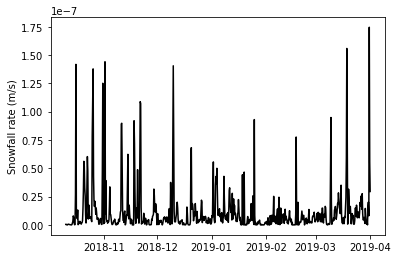

In [30]:
%matplotlib inline
plt.figure()
plt.plot(erai_snowfall_maud_rise,'k')
plt.ylabel('Snowfall rate (m/s)');

The utility ``et.create_reanalysis_series()`` can also calculate average values within a bounding box (``avg_box``), representing \[lon_E,lon_W,lat_S,lat_N\]:

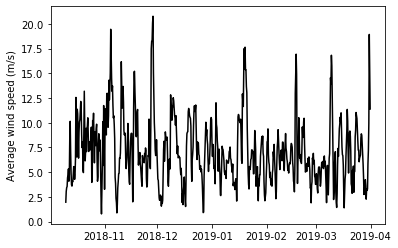

In [31]:
erai_SH_analysis = et.load_ecmwf('Data/ERA_Interim_processed/','erai_SH_analysis.nc')

# average wind speed from 64-66°S, 5°W-0°E:
erai_ws_maud_rise = et.create_reanalysis_index(erai_SH_analysis,param_name='si10',avg_box=[-5,0,-66,-64])

# plot
plt.figure()
plt.plot(erai_ws_maud_rise,'k')
plt.ylabel('Average wind speed (m/s)');

It's easy to index into the Pandas series, using, e.g.:

In [32]:
erai_ws_maud_rise.loc['2019-02-01']

time
2019-02-01 00:00:00    5.715244
2019-02-01 06:00:00    8.072490
2019-02-01 12:00:00    8.115422
2019-02-01 18:00:00    9.372627
dtype: float32

In [33]:
mean(erai_ws_maud_rise.loc['2019-02-01'])

7.81894588470459

In [34]:
erai_ws_maud_rise.loc['2019-02-02-06':'2019-02-02-12']

time
2019-02-02 06:00:00    6.032369
2019-02-02 12:00:00    5.725710
dtype: float32